# Tablas dinámicas

Hemos visto cómo la abstracción ``GroupBy`` nos permite explorar las relaciones dentro de un conjunto de datos.
Una *tabla pivotante* es una operación similar que suele verse en las hojas de cálculo y otros programas que operan con datos tabulares.
La tabla pivotante toma como entrada datos simples en forma de columnas y agrupa las entradas en una tabla bidimensional que proporciona un resumen multidimensional de los datos.
La diferencia entre las tablas pivotantes y ``GroupBy`` a veces puede causar confusión; me ayuda pensar en las tablas pivotantes como una versión *multidimensional* de la agregación ``GroupBy``.
Es decir, divides-aplicas-combinas, pero tanto la división como la combinación no se producen en un índice unidimensional, sino en una cuadrícula bidimensional.

## Motivación de las tablas dinámicas

Para los ejemplos de esta sección, utilizaremos la base de datos de pasajeros del *Titanic*, disponible a través de la biblioteca Seaborn (ver [Visualización con Seaborn](04.14-Visualización-con-Seaborn.ipynb)):

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [ ]:
titanic.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who adult_male deck  embark_town alive  alone  
0    man       True  NaN  Southampton    no  False  
1  woman      False    C    Cherbourg   yes  False  
2  woman      False  NaN  Southampton   yes   True  
3  woman      False    C  Southampton   yes  False  
4    man       True  NaN  Southampton    no   True

Contiene una gran cantidad de información sobre cada uno de los pasajeros de ese malogrado viaje, incluyendo el género, la edad, la clase, la tarifa pagada y mucho más.

## Tablas dinámicas a mano

Para empezar a aprender más sobre estos datos, podríamos empezar por agrupar según el género, el estado de supervivencia o alguna combinación de ellos.
Si ha leído la sección anterior, podría verse tentado a aplicar una operación ``GroupBy``; por ejemplo, veamos la tasa de supervivencia por género:

In [ ]:
titanic.groupby('sex')[['survived']].mean()

survived
sex             
female  0.742038
male    0.188908

Esto nos da inmediatamente una idea: en general, tres de cada cuatro hembras a bordo sobrevivieron, mientras que sólo uno de cada cinco varones lo hizo.

Esto es útil, pero podríamos ir un paso más allá y analizar la supervivencia por sexo y, por ejemplo, por clase.
Utilizando el vocabulario de ``GroupBy``, podríamos proceder de la siguiente manera
agrupamos por clase y sexo, seleccionamos la supervivencia, aplicamos una media agregada, combinamos los grupos resultantes, y luego descomponemos el índice jerárquico para revelar la multidimensionalidad oculta. En código:

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

Esto nos da una mejor idea de cómo el género y la clase afectan a la supervivencia, pero el código empieza a parecer un poco confuso.
Aunque cada paso de esta cadena tiene sentido a la luz de las herramientas que hemos discutido previamente, la larga cadena de código no es particularmente fácil de leer o utilizar.
Este ``GroupBy`` bidimensional es lo suficientemente común como para que Pandas incluya una rutina de conveniencia, ``pivot_table``, que maneja sucintamente este tipo de agregación multidimensional.

## Sintaxis de la tabla dinámica

Aquí está el equivalente a la operación anterior utilizando el método ``pivot_table`` de ``DataFrame``:

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class')

class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

Esto es mucho más fácil de leer que el enfoque "por grupos", y produce el mismo resultado.
Como cabría esperar de un crucero transatlántico de principios del siglo XX, el gradiente de supervivencia favorece tanto a las mujeres como a las clases superiores.
Las mujeres de primera clase sobrevivieron con casi total seguridad (¡hola, Rose!), mientras que sólo uno de cada diez hombres de tercera clase sobrevivió (¡lo siento, Jack!).

### Tablas dinámicas de varios niveles

Al igual que en el ``GroupBy``, la agrupación en las tablas dinámicas puede especificarse con múltiples niveles, y a través de una serie de opciones.
Por ejemplo, podríamos estar interesados en ver la edad como una tercera dimensión.
Agruparemos la edad utilizando la función ``pd.cut``:

In [ ]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

También podemos aplicar la misma estrategia al trabajar con las columnas; añadamos información sobre la tarifa pagada utilizando ``pd.qcut`` para calcular automáticamente los cuantiles:

In [ ]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            [0, 14.454]                     (14.454, 512.329]            \
class                 First    Second     Third             First    Second   
sex    age                                                                    
female (0, 18]          NaN  1.000000  0.714286          0.909091  1.000000   
       (18, 80]         NaN  0.880000  0.444444          0.972973  0.914286   
male   (0, 18]          NaN  0.000000  0.260870          0.800000  0.818182   
       (18, 80]         0.0  0.098039  0.125000          0.391304  0.030303   

fare                       
class               Third  
sex    age                 
female (0, 18]   0.318182  
       (18, 80]  0.391304  
male   (0, 18]   0.178571  
       (18, 80]  0.192308

El resultado es una agregación cuatridimensional con índices jerárquicos (véase [Indexación jerárquica](03.05-Indexación-jerárquica.ipynb)), mostrada en una cuadrícula que demuestra la relación entre los valores.

### Opciones adicionales de la tabla dinámica

La firma completa del método ``pivot_table`` de ``DataFrame`` es la siguiente

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

Ya hemos visto ejemplos de los tres primeros argumentos; aquí echaremos un vistazo rápido a los restantes.
Dos de las opciones, ``fill_value`` y ``dropna```, tienen que ver con los datos que faltan y son bastante sencillas; no mostraremos ejemplos de ellas aquí.

La palabra clave ``aggfunc`` controla qué tipo de agregación se aplica, que es una media por defecto.
Al igual que en GroupBy, la especificación de la agregación puede ser una cadena que represente una de las opciones más comunes (por ejemplo, ``sum``, ``mean``, ``count``, ``min``, ``max``, etc.) o una función que implemente una agregación (por ejemplo, ``np.sum()``, ``min()``, ``sum()``, etc.).
Además, puede especificarse como un diccionario que asigna una columna a cualquiera de las opciones deseadas anteriormente:

In [ ]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810     91.0   70.0  72.0
male     67.226127  19.741782  12.661633     45.0   17.0  47.0

Fíjate también en que hemos omitido la palabra clave ``values``; al especificar una asignación para ``aggfunc``, ésta se determina automáticamente.

A veces es útil calcular los totales a lo largo de cada agrupación.
Esto puede hacerse mediante la palabra clave ``margins``:

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class      First    Second     Third       All
sex                                           
female  0.968085  0.921053  0.500000  0.742038
male    0.368852  0.157407  0.135447  0.188908
All     0.629630  0.472826  0.242363  0.383838

Aquí esto nos da automáticamente información sobre la tasa de supervivencia agnóstica por género, la tasa de supervivencia agnóstica por género y la tasa de supervivencia global del 38%.
La etiqueta de los márgenes se puede especificar con la palabra clave ``margins_name``, que por defecto es ``"All"``.

## Ejemplo: Datos de natalidad

Como ejemplo más interesante, veamos los datos de libre acceso sobre los nacimientos en Estados Unidos, proporcionados por los Centros de Control de Enfermedades (CDC).
Estos datos pueden encontrarse en https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(este dataset ha sido analizado ampliamente por Andrew Gelman y su grupo; véase, por ejemplo, [esta entrada de blog](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [ ]:
# shell command to download the data:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [ ]:
births = pd.read_csv('data/births.csv')

Si echamos un vistazo a los datos, vemos que son relativamente sencillos: contienen el número de nacimientos agrupados por fecha y sexo:

In [ ]:
births.head()

year  month day gender  births
0  1969      1   1      F    4046
1  1969      1   1      M    4440
2  1969      1   2      F    4454
3  1969      1   2      M    4548
4  1969      1   3      F    4548

We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

In [ ]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender         F         M
decade                    
1960     1753634   1846572
1970    16263075  17121550
1980    18310351  19243452
1990    19479454  20420553
2000    18229309  19106428

Inmediatamente vemos que los nacimientos masculinos superan a los femeninos en cada década.
Para ver esta tendencia un poco más claramente, podemos utilizar las herramientas de trazado incorporadas en Pandas para visualizar el número total de nacimientos por año (ver [Introducción a Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) para una discusión de trazado con Matplotlib):

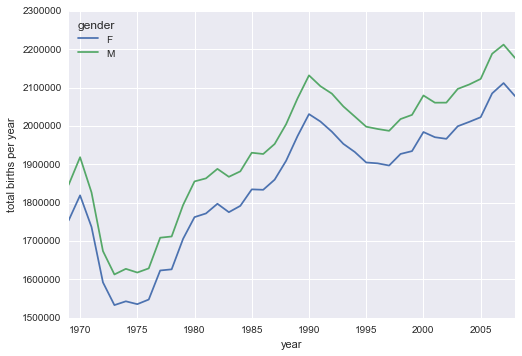

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

Con una simple tabla dinámica y el método ``plot()``, podemos ver inmediatamente la tendencia anual de los nacimientos por género. A ojo, parece que en los últimos 50 años los nacimientos masculinos han superado a los femeninos en aproximadamente un 5%.

### Más exploración de datos

Aunque esto no está necesariamente relacionado con la tabla dinámica, hay algunas características más interesantes que podemos extraer de este conjunto de datos utilizando las herramientas de Pandas cubiertas hasta este punto.
Debemos empezar por limpiar un poco los datos, eliminando los valores atípicos causados por fechas mal escritas (por ejemplo, el 31 de junio) o valores perdidos (por ejemplo, el 99 de junio).
Una forma fácil de eliminar todo esto de una vez es cortar los valores atípicos; lo haremos mediante una operación robusta de recorte de sigma:

In [ ]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

Esta línea final es una estimación robusta de la media de la muestra, donde el 0,74 proviene del rango intercuartil de una distribución gaussiana (Puedes aprender más sobre las operaciones de sigma-clipping en un libro del que soy coautor con Željko Ivezić, Andrew J. Connolly y Alexander Gray: ["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html) (Princeton University Press, 2014)).

Con esto podemos utilizar el método ``query()`` (discutido más adelante en [High-Performance Pandas: ``eval()`` y ``query()``](03.12-Performance-Eval-and-Query.ipynb)) para filtrar las filas con nacimientos fuera de estos valores:

In [ ]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

A continuación, establecemos la columna ``day`` en enteros; antes era una cadena porque algunas columnas del conjunto de datos contenían el valor ``'null'``:

In [ ]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

Por último, podemos combinar el día, el mes y el año para crear un índice de fecha (véase [Trabajo con series temporales](03.11-Trabajo-con-serie- temporales.ipynb)).
Esto nos permite calcular rápidamente el día de la semana correspondiente a cada fila:

In [ ]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

De este modo, podemos trazar los nacimientos por día de la semana durante varias décadas:

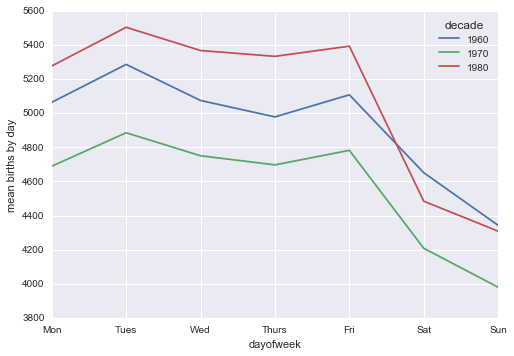

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Al parecer, los nacimientos son ligeramente menos frecuentes los fines de semana que los días laborables. Obsérvese que faltan los años 90 y 2000 porque los datos del CDC sólo contienen el mes de nacimiento a partir de 1989.

Otra visión interesante es la de representar el número medio de nacimientos por día del *año*.
Agrupemos primero los datos por mes y día por separado:

In [ ]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

1  1    4009.225
   2    4247.400
   3    4500.900
   4    4571.350
   5    4603.625
Name: births, dtype: float64

El resultado es un índice múltiple sobre meses y días.
Para que sea más fácil de trazar, convirtamos estos meses y días en una fecha asociándolos a una variable de año ficticia (¡asegurándonos de elegir un año bisiesto para que el 29 de febrero se maneje correctamente!)

In [ ]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

2012-01-01    4009.225
2012-01-02    4247.400
2012-01-03    4500.900
2012-01-04    4571.350
2012-01-05    4603.625
Name: births, dtype: float64

Centrándonos sólo en el mes y el día, ahora tenemos una serie temporal que refleja el número medio de nacimientos por fecha del año.
A partir de ahí, podemos utilizar el método ``plot`` para representar los datos. Esto revela algunas tendencias interesantes:

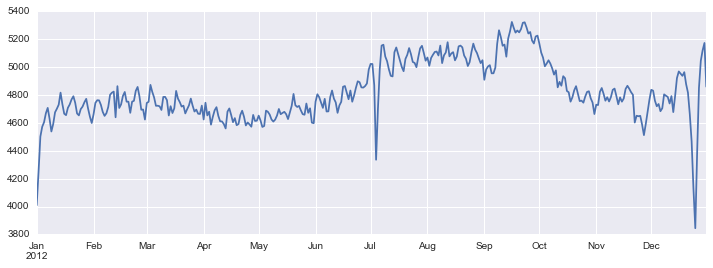

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

En particular, la característica más llamativa de este gráfico es el descenso de la natalidad en los días festivos de EE.UU. (por ejemplo, el Día de la Independencia, el Día del Trabajo, Acción de Gracias, Navidad, Año Nuevo), aunque es probable que esto refleje las tendencias de los nacimientos programados/inducidos más que algún efecto psicosomático profundo en los nacimientos naturales.
Para más información sobre esta tendencia, véase el análisis y los enlaces de la entrada del [blog de Andrew Gelman](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) sobre el tema.
Volveremos a esta figura en [Ejemplo: Efecto de las vacaciones en los nacimientos en EE.UU.](04.09-Text-and-Annotation.ipynb#Example:-Effect-of-Holidays-on-US-Births), donde utilizaremos las herramientas de Matplotlib para anotar este gráfico.

Si observamos este breve ejemplo, podemos ver que muchas de las herramientas de Python y Pandas que hemos visto hasta ahora pueden combinarse y utilizarse para obtener información de una gran variedad de conjuntos de datos.
Veremos algunas aplicaciones más sofisticadas de estas manipulaciones de datos en futuras secciones.